In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"usando dispositivo: {device}")

usando dispositivo: cuda


In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.LazyConv2d(32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.LazyConv2d(64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )

        self.fc = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(128)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

    

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_network):
        super().__init__()
        self.embedding_network = embedding_network #

    # Certifique-se de que o nome 'forward' esteja escrito exatamente assim
    def forward(self, anchor, positive, negative):
        a = self.embedding_network(anchor)    #
        p = self.embedding_network(positive)  #
        n = self.embedding_network(negative)  #
        return a, p, n #

In [5]:
class FashionMNISTTripletDataset(Dataset):
    # Adicionamos 'train=True' aqui para o código da imagem 5 não quebrar
    def __init__(self, train=True):
        # Carrega o banco de dados original
        self.base = datasets.FashionMNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transforms.ToTensor()
        )
        
        # Cria as "gavetas" automáticas (defaultdict)
        self.gavetas = defaultdict(list)
        
        # Organiza as imagens por categoria
        for i in range(len(self.base)):
            img, label = self.base[i]
            self.gavetas[label].append(img)
            
        self.lista_labels = list(self.gavetas.keys())

    def __len__(self):
        return len(self.base)

    def __getitem__(self, index):
        # Sorteio da Âncora e Positivo (Mesma categoria)
        label_a = random.choice(self.lista_labels)
        ancora, positivo = random.sample(self.gavetas[label_a], 2)
        
        # Sorteio do Negativo (Categoria diferente)
        label_n = random.choice(self.lista_labels)
        while label_n == label_a:
            label_n = random.choice(self.lista_labels)
        negativo = random.choice(self.gavetas[label_n])
        
        # Retorna o trio como na sua imagem
        return ancora, positivo, negativo
        

In [6]:
EPOCHS = 5
# 1. Preparar os Dados
triplet_dataset = FashionMNISTTripletDataset(train=True)
# O DataLoader embaralha e cria os lotes (batches) para o treino
train_loader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)

# 2. Instanciar os Modelos
embedding_net = EmbeddingNet().to(device)
# Passamos a rede de embedding para o modelo siamês
model = SiameseNetwork(embedding_net).to(device)

# 3. Definir Perda e Otimizador
# O objetivo dessa perda é: distância(a, p) < distância(a, n) por uma margem de 1.0
loss_function = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Loop de Treinamento ---
print("Iniciando o treinamento...")
model.train() 

for epoch in range(EPOCHS):
    total_loss_epoch = 0

    # Itera sobre o dataloader para pegar os lotes de trios 
    for batch_idx, (anchor, positive, negative) in enumerate(train_loader): 
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad() 
        anchor_out, positive_out, negative_out = model(anchor, positive, negative)
        loss = loss_function(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print(f"Época [{epoch+1}/{EPOCHS}] - Batch {batch_idx} - Perda: {loss.item():.4f}")

    avg_loss = total_loss_epoch / len(train_loader)
    print(f"=== Fim da Época {epoch+1}, Perda Média: {avg_loss:.4f} ===\n")

print("Treinamento concluído!")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.0MB/s]


Iniciando o treinamento...
Época [1/5] - Batch 0 - Perda: 0.9667
Época [1/5] - Batch 100 - Perda: 0.3736
Época [1/5] - Batch 200 - Perda: 0.3284
Época [1/5] - Batch 300 - Perda: 0.2042
Época [1/5] - Batch 400 - Perda: 0.2203
Época [1/5] - Batch 500 - Perda: 0.2424
Época [1/5] - Batch 600 - Perda: 0.2465
Época [1/5] - Batch 700 - Perda: 0.1266
Época [1/5] - Batch 800 - Perda: 0.2250
Época [1/5] - Batch 900 - Perda: 0.1676
=== Fim da Época 1, Perda Média: 0.2466 ===

Época [2/5] - Batch 0 - Perda: 0.1552
Época [2/5] - Batch 100 - Perda: 0.2273
Época [2/5] - Batch 200 - Perda: 0.1494
Época [2/5] - Batch 300 - Perda: 0.1648
Época [2/5] - Batch 400 - Perda: 0.1884
Época [2/5] - Batch 500 - Perda: 0.1212
Época [2/5] - Batch 600 - Perda: 0.2071
Época [2/5] - Batch 700 - Perda: 0.1572
Época [2/5] - Batch 800 - Perda: 0.1815
Época [2/5] - Batch 900 - Perda: 0.0680
=== Fim da Época 2, Perda Média: 0.1628 ===

Época [3/5] - Batch 0 - Perda: 0.1234
Época [3/5] - Batch 100 - Perda: 0.1495
Época [3/

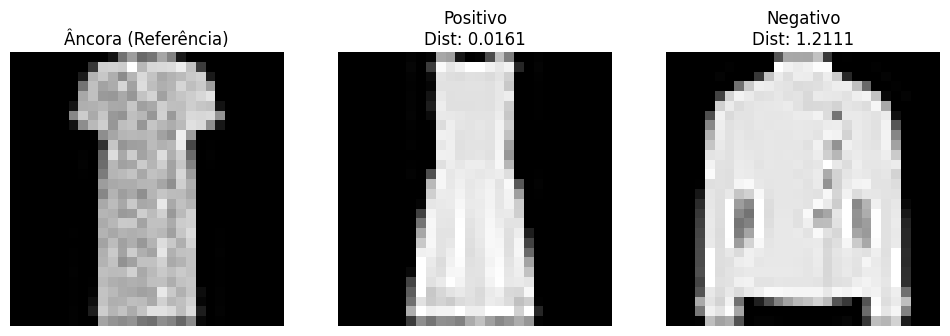

Distância Positiva: 0.0161
Distância Negativa: 1.2111


In [7]:
# Pega um trio do dataset para testar
# 1. Pega um trio do dataset para testar
a, p, n = triplet_dataset[0]

# 2. Calcula as distâncias (seu código original)
model.eval() # Coloca em modo de avaliação
with torch.no_grad():
    vec_a = embedding_net(a.unsqueeze(0).to(device))
    vec_p = embedding_net(p.unsqueeze(0).to(device))
    vec_n = embedding_net(n.unsqueeze(0).to(device))

dist_pos = torch.dist(vec_a, vec_p).item()
dist_neg = torch.dist(vec_a, vec_n).item()

# 3. PRINTAR AS IMAGENS
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Mostra a Âncora
ax[0].imshow(a.squeeze(), cmap='gray')
ax[0].set_title("Âncora (Referência)")
ax[0].axis('off')

# Mostra o Positivo
ax[1].imshow(p.squeeze(), cmap='gray')
ax[1].set_title(f"Positivo\nDist: {dist_pos:.4f}")
ax[1].axis('off')

# Mostra o Negativo
ax[2].imshow(n.squeeze(), cmap='gray')
ax[2].set_title(f"Negativo\nDist: {dist_neg:.4f}")
ax[2].axis('off')

plt.show()

print(f"Distância Positiva: {dist_pos:.4f}")
print(f"Distância Negativa: {dist_neg:.4f}")